In [1]:
# from https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

import nltk
nltk.download('stopwords')
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
# %matplotlib inline
import parquet
import os

# Prepare stopwords
# NLTK Stop words
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/tfai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-05-04 17:13:39.877930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def remove_stopwords(texts):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    # Build the bigram
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    # Faster way to get a sentence clubbed as a bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    # Build the trigram models
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    # nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [3]:
# Tokenize words and cleanup the text
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            
    #deacc=True removes punctuations

def preprocess(dataFrameName):
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

    # load daaset
    path = os.getcwd()
    # df = pd.read_parquet('{}/project_data/arxiv_climate_change.parquet'.format(path), engine='auto')
    
    
    filePath = '%s/project_data/%s.parquet' % (path,dataFrameName)

    df = pd.read_parquet(filePath)

    # Remove newline characters
    # Convert to list 
    data = df.abstract.values.tolist()  
    # Remove new line characters 
    data = [re.sub('\s+', ' ', sent) for sent in data]  
    # Remove distracting single quotes 
    data = [re.sub("\'", "", sent) for sent in data]  
    data_words = list(sent_to_words(data))

    # Call preprocessing functions in order
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # print(data_lemmatized[:1])

    return data_lemmatized
    

<>:25: DeprecationWarning: invalid escape sequence '\s'
<>:25: DeprecationWarning: invalid escape sequence '\s'
/var/folders/nk/cmv723pj6n38_mwnlhj_7z3m0000gp/T/ipykernel_3275/2574915753.py:25: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [5]:
# Create Dictionary and Corpus needed for Topic Modeling
    # Create Dictionary 

def get_corpus(df):
    data_lemmatized = preprocess(df)
    id2word = corpora.Dictionary(data_lemmatized)  
        # Create Corpus 
    texts = data_lemmatized  
        # Term Document Frequency 
    corpus = [id2word.doc2bow(text) for text in texts]  

    return(corpus, id2word,data_lemmatized)




In [6]:
def build_model(df, num_topics):
    # Building topic model
    corpus, id2word,data_lemmatized = get_corpus(df)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1, # determines how often the model parameters should be updated
                                            chunksize=100, # the number of documents to be used in each training chunk
                                            passes=10, # the total number of training passes
                                            alpha='auto',
                                            per_word_topics=True)


    # Print the keyword of topics
    # pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    # Evaluate topic models

    # Compute model Perplexity and Coherence score
    # Compute Perplexity
    # print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    # print('\nCoherence Score: ', coherence_lda)
    #Higher the topic coherence, the topic is more human interpretable.
    return(lda_model.log_perplexity(corpus),coherence_lda) 

In [8]:
performance_vec = []
for i in range(16,26):

    performance_vec.append(build_model('arxiv_climate_change',i))
    


Perplexity:  -11.099614175498273

Coherence Score:  0.4655382118582177

Perplexity:  -11.307064356142975

Coherence Score:  0.4565442238531724

Perplexity:  -11.509889953943015

Coherence Score:  0.46843045486396484

Perplexity:  -11.72681057902166

Coherence Score:  0.42513288849964

Perplexity:  -11.936132097892376

Coherence Score:  0.4483601133207788

Perplexity:  -12.139280101196972

Coherence Score:  0.4224173504145129

Perplexity:  -12.37023552193815

Coherence Score:  0.4425384174354132

Perplexity:  -12.578028463079923

Coherence Score:  0.42263086175164255

Perplexity:  -12.79375460606321

Coherence Score:  0.44698116718227404

Perplexity:  -13.00777181756122

Coherence Score:  0.4422423289631795


In [11]:
perplex_vec = [-11.099614175498273,-11.307064356142975,-11.509889953943015,-11.72681057902166,-11.936132097892376, -12.139280101196972,-12.37023552193815,-12.578028463079923, -12.79375460606321,-13.00777181756122]
coherence_vec = [0.4655382118582177,0.4565442238531724,0.46843045486396484,0.42513288849964,0.4483601133207788,0.4224173504145129,0.4425384174354132,0.42263086175164255,0.44698116718227404,0.4422423289631795]

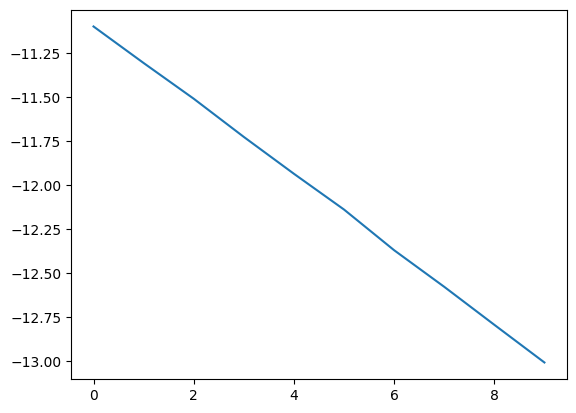

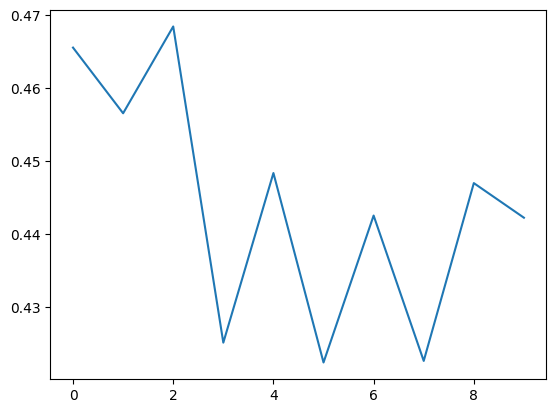

In [27]:
fig,ax = plt.subplots(1,1)
ax.plot(perplex_vec)
fig,ax = plt.subplots(1,1)
ax.plot(coherence_vec)